In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).first()
most_recent_date


('2017-08-23',)

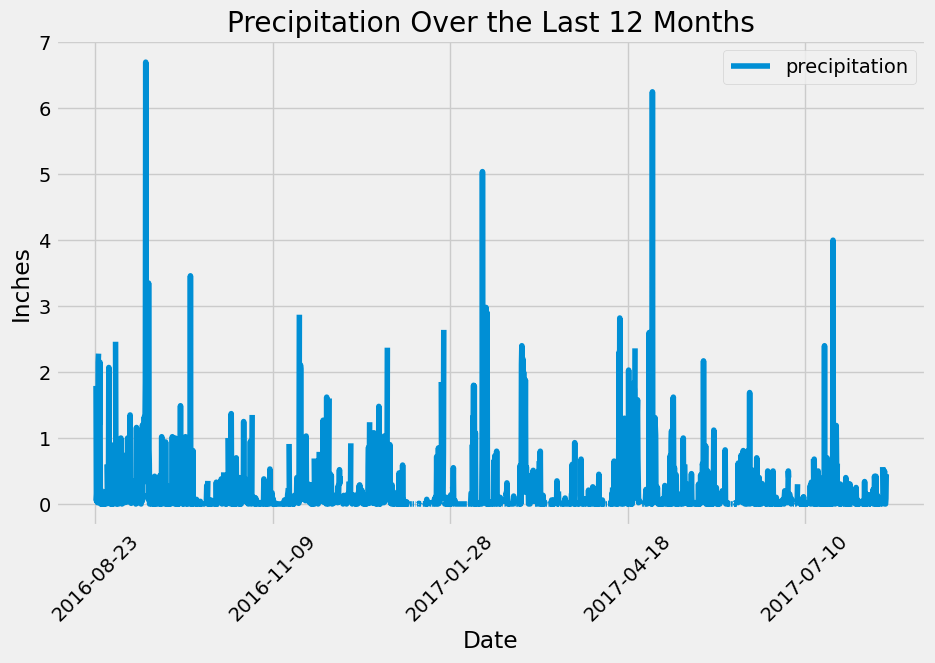

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
most_recent_date_dt = datetime.strptime(most_recent_date[0], '%Y-%m-%d')
one_year_ago_dt = most_recent_date_dt - timedelta(days=365)
one_year_ago = (one_year_ago_dt.strftime('%Y-%m-%d'),)
one_year_ago

# Perform a query to retrieve the data and precipitation scores
precip_data = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= one_year_ago[0])
    .all()
)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip_data, columns=["date", "precipitation"])

# Sort the dataframe by date
precip_df.set_index("date", inplace=True)
precip_df = precip_df.sort_index()
precip_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(
    figsize=(10, 6),
    title="Precipitation Over the Last 12 Months",
    legend=True,
    xlabel="Date",
    ylabel="Inches",
)
plt.xticks(rotation=45)
plt.show()


In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).all()
total_stations


[(9,)]

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)
most_active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = most_active_stations[0][0]

most_active_station_temps = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs),
    )
    .filter(Measurement.station == most_active_station)
    .all()
)
most_active_station_temps

[(54.0, 85.0, 71.66378066378067)]

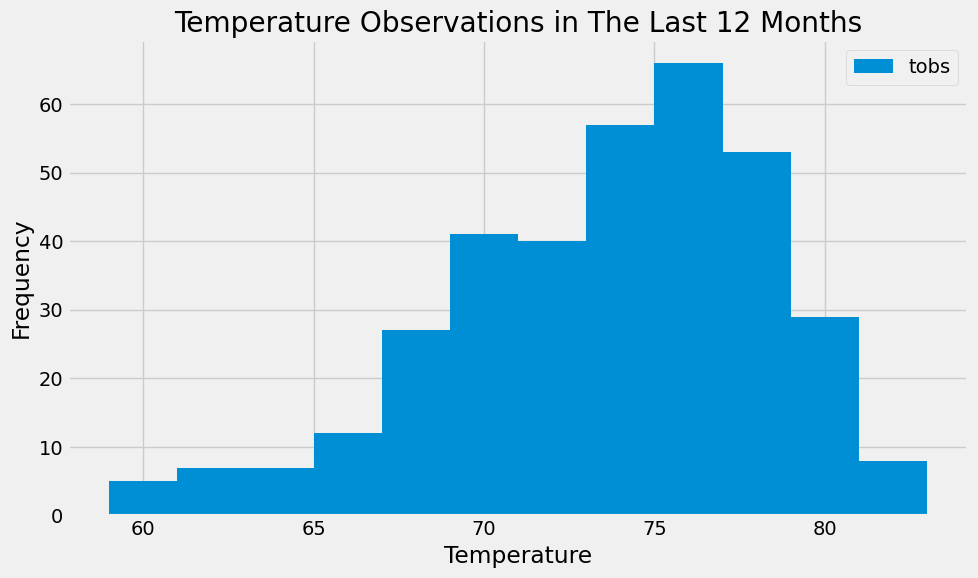

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_temps = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active_station)
    .filter(Measurement.date >= one_year_ago[0])
    .all()
)

temp_list = [temp[0] for temp in most_active_station_temps]

plt.figure(figsize=(10, 6))
plt.hist(temp_list, bins=12, label='tobs')
plt.title('Temperature Observations in The Last 12 Months')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [20]:
# Close Session
session.close()